In [1]:
import math
import random
import matplotlib.pyplot as plt
from setuptools.command.test import test

In [45]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
def rand(a, b):
    return (b-a)*random.random() + a

In [4]:
def makeMatrix(I, J, fill=0.0):
    m = []
    for i in range(I):
        m.append([fill]*J)
    return m

In [5]:
def sigmoid(x):
    #return math.tanh(x)
    return 1 / (1 + math.exp(-x))

In [6]:
def dsigmoid(y):
    #return 1.0 - y ** 2
    return (1-y)*y

In [7]:
def plot(inputs, outputs, actual):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(inputs, actual, 'b-')
    ax1.plot(inputs, outputs, 'r.')
    plt.draw()

In [8]:
def convert_result(prediction):
    result = []
    for value in prediction:
        if(value[0] > 0.8):
            result.append(1)
        else:
            result.append(0)
    return result

In [9]:
def read_data():
    data = pd.read_csv('heart2.csv', sep=",")

    data.sex = data.sex.astype('category')
    data.cp = data.cp.astype('category')
    data.fbs = data.fbs.astype('category')
    data.restecg = data.restecg.astype('category')
    data.exang = data.exang.astype('category')
    data.ca = data.ca.astype('category')
    data.slope = data.slope.astype('category')
    data.thal = data.thal.astype('category')
    
    return data

In [10]:
class NN:
    def __init__(self, ni, nh, no, regression = False):

        self.regression = regression

        #Number of input, hidden and output nodes.
        self.ni = ni  + 1 # +1 for bias node
        self.nh = nh  + 1 # +1 for bias node
        self.no = no

        # activations for nodes
        self.ai = [1.0]*self.ni
        self.ah = [1.0]*self.nh
        self.ao = [1.0]*self.no

        # create weights
        self.wi = makeMatrix(self.ni, self.nh)
        self.wo = makeMatrix(self.nh, self.no)

        # set them to random vaules
        for i in range(self.ni):
            for j in range(self.nh):
                self.wi[i][j] = rand(-1, 1)
        for j in range(self.nh):
            for k in range(self.no):
                self.wo[j][k] = rand(-1, 1)

        # last change in weights for momentum
        self.ci = makeMatrix(self.ni, self.nh)
        self.co = makeMatrix(self.nh, self.no)


    def forwardPropagate(self, inputs):

        if len(inputs) != self.ni-1:
            print(len(inputs), " -- ",self.ni-1)
            raise(ValueError,  'wrong number of inputs')

        # input activations
        for i in range(self.ni - 1):
            self.ai[i] = inputs[i]

        # hidden activations
        for j in range(self.nh - 1):
            total = 0.0
            for i in range(self.ni):
                total += self.ai[i] * self.wi[i][j]
            self.ah[j] = sigmoid(total)

        # output activations
        for k in range(self.no):
            total = 0.0
            for j in range(self.nh):
                total += self.ah[j] * self.wo[j][k]
            self.ao[k] = total
            if not self.regression:
                self.ao[k] = sigmoid(total)


        return self.ao[:]


    def backPropagate(self, targets, N, M):
        if len(targets) != self.no:
            raise(ValueError, 'wrong number of target values')
        # calculate error terms for output


        output_deltas = [0.0] * self.no


        for k in range(self.no):

            output_deltas[k] = targets[k] - self.ao[k]
            if not self.regression:
                output_deltas[k] = dsigmoid(self.ao[k]) * output_deltas[k]


        # calculate error terms for hidden
        hidden_deltas = [0.0] * self.nh
        for j in range(self.nh):
            error = 0.0
            for k in range(self.no):
                error += output_deltas[k]*self.wo[j][k]
            hidden_deltas[j] = dsigmoid(self.ah[j]) * error

        # update output weights
        for j in range(self.nh):
            for k in range(self.no):
                change = output_deltas[k]*self.ah[j]
                self.wo[j][k] = self.wo[j][k] + N*change + M*self.co[j][k]
                self.co[j][k] = change

        # update input weights
        for i in range(self.ni):
            for j in range(self.nh):
                change = hidden_deltas[j]*self.ai[i]
                self.wi[i][j] = self.wi[i][j] + N*change + M*self.ci[i][j]
                self.ci[i][j] = change
        # calculate error
        error = 0.0
        for k in range(len(targets)):
            error += 0.5*((targets[k]-self.ao[k])**2)
        return error


    def predict(self, test_x):
        prediction = []
        for p in test_x:
            prediction.append(self.forwardPropagate(p))
        
        result = convert_result(prediction)

        return result


    def weights(self):
        print('Input weights:')
        for i in range(self.ni):
            print(self.wi[i])
        print('Output weights:')
        for j in range(self.nh):
            print(self.wo[j])

    def train(self, train_x, train_y, iterations=1000, N=0.5, M=0.1, verbose = False):
        """Train the neural network.

        N is the learning rate.
        M is the momentum factor.
        """
        err = []
        for i in range(iterations):
            error = 0.0
            for x,y in zip(train_x,train_y):
                self.forwardPropagate(x)
                tmp = self.backPropagate(y, N, M)
                error += tmp
            if i % 50 == 0:
                print (i,'error %-14f' % error)
                err.append((i,error))
        
        return err;

In [11]:
def demoClassification(train_x,train_y):
    # create a network with two input, two hidden, and one output nodes
    model = NN(22,19 ,1, regression = False)

    # train it with some patterns then test it.
    err = model.train(train_x,train_y, 40000, 0.001,0.001)
    
    return model, err

In [12]:
x = read_data()

In [13]:
y = x['target']
del x['target']

In [14]:
y = pd.DataFrame(y)
x = pd.get_dummies(x, drop_first=True)

In [15]:
data_scaled = StandardScaler().fit_transform(x)
data_scaled = pd.DataFrame(data=data_scaled, columns=x.columns)

/usr/local/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/anaconda/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [16]:
x_train, x_test, y_train, y_test = train_test_split(data_scaled, y, test_size=0.20, random_state=42)

In [17]:
train_x = x_train.values.tolist()
train_y = y_train.values.tolist()

In [18]:
test_x = x_test.values.tolist()
test_y = y_test.values.tolist()

In [19]:
model, err = demoClassification(train_x,train_y)

0 error 54.505410     
50 error 20.071425     
100 error 16.424997     
150 error 14.696974     
200 error 13.619050     
250 error 12.836154     
300 error 12.215747     
350 error 11.698845     
400 error 11.254769     
450 error 10.865089     
500 error 10.517584     
550 error 10.203781     
600 error 9.917702      
650 error 9.654987      
700 error 9.412203      
750 error 9.186394      
800 error 8.974930      
850 error 8.775574      
900 error 8.586570      
950 error 8.406659      
1000 error 8.235005      
1050 error 8.071075      
1100 error 7.914534      
1150 error 7.765157      
1200 error 7.622748      
1250 error 7.487066      
1300 error 7.357784      
1350 error 7.234484      
1400 error 7.116680      
1450 error 7.003868      
1500 error 6.895554      
1550 error 6.791281      
1600 error 6.690641      
1650 error 6.593271      
1700 error 6.498855      
1750 error 6.407113      
1800 error 6.317799      
1850 error 6.230695      
1900 error 6.145603      
1950 erro

15600 error 1.651678      
15650 error 1.650892      
15700 error 1.650112      
15750 error 1.649340      
15800 error 1.648575      
15850 error 1.647817      
15900 error 1.647066      
15950 error 1.646321      
16000 error 1.645583      
16050 error 1.644851      
16100 error 1.644126      
16150 error 1.643407      
16200 error 1.642695      
16250 error 1.641989      
16300 error 1.641289      
16350 error 1.640595      
16400 error 1.639907      
16450 error 1.639225      
16500 error 1.638549      
16550 error 1.637878      
16600 error 1.637214      
16650 error 1.636555      
16700 error 1.635901      
16750 error 1.635253      
16800 error 1.634611      
16850 error 1.633974      
16900 error 1.633342      
16950 error 1.632715      
17000 error 1.632094      
17050 error 1.631478      
17100 error 1.630867      
17150 error 1.630260      
17200 error 1.629659      
17250 error 1.629063      
17300 error 1.628472      
17350 error 1.627885      
17400 error 1.627303      
1

30800 error 1.554245      
30850 error 1.554121      
30900 error 1.553997      
30950 error 1.553874      
31000 error 1.553751      
31050 error 1.553629      
31100 error 1.553507      
31150 error 1.553386      
31200 error 1.553265      
31250 error 1.553145      
31300 error 1.553025      
31350 error 1.552906      
31400 error 1.552787      
31450 error 1.552669      
31500 error 1.552551      
31550 error 1.552434      
31600 error 1.552317      
31650 error 1.552201      
31700 error 1.552085      
31750 error 1.551969      
31800 error 1.551854      
31850 error 1.551740      
31900 error 1.551626      
31950 error 1.551512      
32000 error 1.551399      
32050 error 1.551286      
32100 error 1.551174      
32150 error 1.551062      
32200 error 1.550951      
32250 error 1.550840      
32300 error 1.550730      
32350 error 1.550620      
32400 error 1.550510      
32450 error 1.550401      
32500 error 1.550292      
32550 error 1.550184      
32600 error 1.550076      
3

In [20]:
error = []
_iter = []

In [21]:
for i,e in err:
    error.append(e)
    _iter.append(i)

Text(0, 0.5, 'Hata')

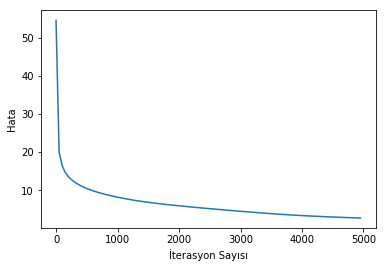

In [51]:
plt.plot(_iter[:100],error[:100])
plt.xlabel("İterasyon Sayısı")
plt.ylabel("Hata")

In [32]:
result = model.predict(test_x)

In [38]:
len(y_test), len(y_train)

(61, 242)

In [33]:
c_matrix = confusion_matrix(test_y, result)
c_matrix

array([[25,  4],
       [ 9, 23]])

In [34]:
tn, fp, fn, tp = c_matrix.ravel()
tn, fp, fn, tp

(25, 4, 9, 23)

In [35]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
precision, recall

(0.8518518518518519, 0.71875)

In [ ]:
precision, recall

In [ ]:
2 * precision * recall / (precision + recall)

In [47]:
def print_score(model, x_train, y_train, x_test, y_test, train=True):
    if train:
        pred = model.predict(x_train)
        model_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{model_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = model.predict(x_test)
        model_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{model_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [48]:
print_score(model, train_x, train_y, test_x, test_y, train=True)
print_score(model, train_x, train_y, test_x, test_y, train=False)

Train Result:
Accuracy Score: 98.76%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1   micro avg   macro avg  weighted avg
f1-score     0.986047    0.988848    0.987603    0.987447      0.987586
precision    1.000000    0.977941    0.987603    0.988971      0.987877
recall       0.972477    1.000000    0.987603    0.986239      0.987603
support    109.000000  133.000000  242.000000  242.000000    242.000000
_______________________________________________
Confusion Matrix: 
 [[106   3]
 [  0 133]]

Test Result:
Accuracy Score: 78.69%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  micro avg  macro avg  weighted avg
f1-score    0.793651   0.779661   0.786885   0.786656      0.786312
precision   0.735294   0.851852   0.786885   0.793573      0.796439
recall      0.862069   0.718750   0.786885   0.790409      0.786885
support    29.000000  32.000000  61.000000  61.000000     61.

In [ ]:
pca = PCA(n_components=2)
pca.fit(x)
x_pca = pca.transform(x)
print("variance ratio:", pca.explained_variance_ratio_)

print("sum:", sum(pca.explained_variance_ratio_))
x["p1"] = x_pca[:, 0]
x["p2"] = x_pca[:, 1]

color = ["red", "green"]

for each in range(2):
    plt.scatter(x.p1[y.target == each], x.p2[y.target == each], color=color[each], label=y.target, alpha=0.5)

plt.xlabel("p1")
plt.ylabel("p2")
plt.show()